In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from PIL import Image
from cloudproject import CloudsClassifier
import io
import time
import numpy as np
import pandas as pd

In [2]:
train_dir = "../data/dataset/train"
valid_dir = "../data/dataset/valid"
img_height = 200
img_width = 200
batch_size = 32

model_name = "ResNet50V2"

classifier = CloudsClassifier(
    train_dir=train_dir,
    valid_dir=valid_dir,
    img_height=img_height,
    img_width=img_width,
    batch_size=batch_size,
)

classifier.load_model(model_name + ".keras")

Création du dataset d'entraînement...
Chargement des données depuis : ../data/dataset/train
Chargement depuis '../data/dataset/train': 1502 images trouvées pour les classes ['altocumulus', 'altostratus', 'cirrocumulus', 'cirrostratus', 'cirrus', 'cumulonimbus', 'cumulus', 'nimbostratus', 'stratocumulus', 'stratus'].

Création du dataset de validation...
Chargement des données depuis : ../data/dataset/valid
Chargement depuis '../data/dataset/valid': 145 images trouvées pour les classes ['altocumulus', 'altostratus', 'cirrocumulus', 'cirrostratus', 'cirrus', 'cumulonimbus', 'cumulus', 'nimbostratus', 'stratocumulus', 'stratus'].

Les datasets sont prêts.
Modèle chargé avec succès depuis ResNet50V2.keras
Dimensions d'entrée du modèle mises à jour : 200x200


0
Image recadrée sauvegardée avec succès.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Prédiction: cirrostratus (88.50%)


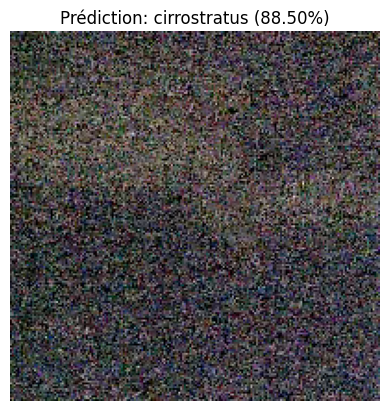

1
Erreur lors de la capture ou du recadrage du screenshot: HTTPConnectionPool(host='localhost', port=52839): Max retries exceeded with url: /session/4ad0d9645e6070e2a10ab4f1f2f0133a/element (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x17ac8b310>: Failed to establish a new connection: [Errno 61] Connection refused'))
2
Erreur lors de la capture ou du recadrage du screenshot: HTTPConnectionPool(host='localhost', port=52839): Max retries exceeded with url: /session/4ad0d9645e6070e2a10ab4f1f2f0133a/element (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x17acbb4d0>: Failed to establish a new connection: [Errno 61] Connection refused'))
3
Erreur lors de la capture ou du recadrage du screenshot: HTTPConnectionPool(host='localhost', port=52839): Max retries exceeded with url: /session/4ad0d9645e6070e2a10ab4f1f2f0133a/element (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x17acbbc50>: Failed to establis

In [4]:
options = Options()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

# Accéder à l'URL de la webcam
url = "https://g0.ipcamlive.com/player/player.php?alias=613202904e8bf&autoplay=1"
driver.get(url)

csv_file = "classes.csv"

count = 10
for i in range(count):
    try:
        print(i)
        # Attendre que l'élément vidéo soit disponible et cliquer dessus
        video_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.TAG_NAME, "video"))
        )
        # video_element.click()
        driver.execute_script("arguments[0].click();", video_element)

        # Attendre un peu pour que la vidéo commence à jouer
        time.sleep(5)

        screenshot = driver.get_screenshot_as_png()
        image = Image.open(io.BytesIO(screenshot))

        # Recadrer l'image (par exemple, la moitié gauche de l'image)
        width, height = image.size
        top = 0
        left = width - height
        right = width
        bottom = height
        cropped_image = image.crop((left, top, right, bottom))

        time_stamp = np.round(time.time(), 0).astype(np.int64)

        cropped_image.save(f"../data/scraped/nuage_{i}.png")
        print("Image recadrée sauvegardée avec succès.")

        # Prédiction
        predicted_class_name, confidence = classifier.predict(f"../data/scraped/nuage_{i}.png")

        try:
            df = pd.read_csv(csv_file)
        except FileNotFoundError:
            df = pd.DataFrame(columns=["image_name", "prediction"])

        new_row = pd.DataFrame(
            [[f"nuage_{i}.png", predicted_class_name]],
            columns=["image_name", "prediction"],
        )
        df = pd.concat([df, new_row], ignore_index=True)

        # Sauvegarder le DataFrame dans le fichier CSV
        df.to_csv(csv_file, index=False)

        time.sleep(10)

    except Exception as e:
        print(f"Erreur lors de la capture ou du recadrage du screenshot: {e}")

    finally:
        # Fermer le navigateur
        driver.quit()